#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션) 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션) 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [6]:
train.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
train.shape

(5881, 562)

In [8]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [10]:
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [11]:
train.isnull().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
target = 'Activity'
x = train.drop(target, axis=1)
y = train.loc[:, target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [14]:
y.value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [15]:
y.head()

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS


In [16]:
y = y.map({'LAYING':0, 'STANDING':1, 'SITTING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})

In [17]:
y.head()

,Activity
0,1
1,0
2,1
3,3
4,5


### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 - base model

In [19]:
nfeatures = x_train.shape[1]
nfeatures

561

In [20]:
model1 = Sequential([Input(shape = (nfeatures,)),
                    Dense(6, activation = 'softmax')])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history1 = model1.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val)).history

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3324 - val_loss: 0.7598
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7143 - val_loss: 0.5594
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5349 - val_loss: 0.4582
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4578 - val_loss: 0.3840
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3875 - val_loss: 0.3451
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3423 - val_loss: 0.3129
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3130 - val_loss: 0.2758
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2821 - val_loss: 0.2527
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2639 - val_loss: 0.2359
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2524 - val_loss: 0.2258
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2431 - val_loss: 0.2103
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

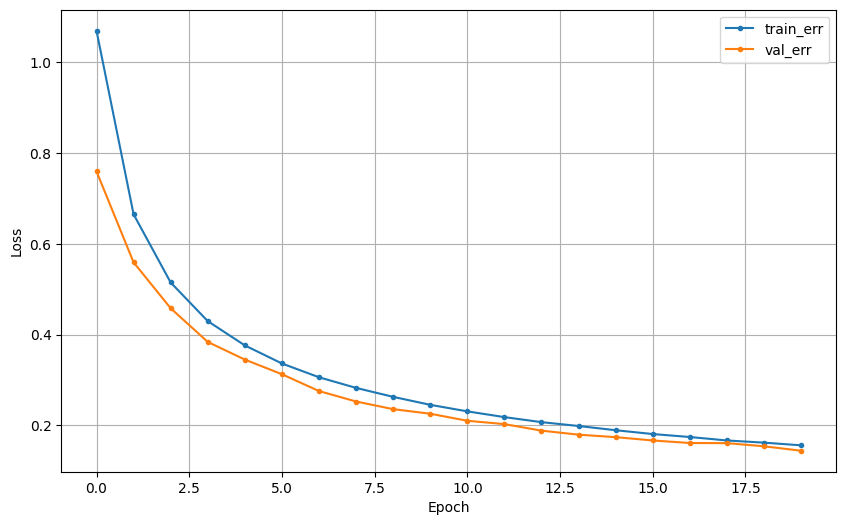

In [22]:
dl_history_plot(history1)

In [23]:
pred = model1.predict(x_val)
pred_1 = pred.argmax(axis=1)

print(confusion_matrix(y_val, pred_1))
print(classification_report(y_val, pred_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[231   0   0   0   0   0]
 [  0 205  21   0   0   0]
 [  2  11 187   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   1 175   1]
 [  0   0   0   0   3 142]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       231
           1       0.95      0.91      0.93       226
           2       0.90      0.94      0.92       200
           3       0.99      0.98      0.99       198
           4       0.97      0.99      0.98       177
           5       0.98      0.98      0.98       145

    accuracy                           0.96      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177



### (2) 모델2 - hidden layer 최소 5개 추가

In [24]:
model2 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history2 = model2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val)).history

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3350 - val_loss: 0.5735
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5293 - val_loss: 0.3108
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2964 - val_loss: 0.2019
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2160 - val_loss: 0.2909
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1922 - val_loss: 0.2037
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1430 - val_loss: 0.1027
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1108 - val_loss: 0.0901
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.0996
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0755 - val_loss: 0.0694
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0660 - val_loss: 0.0971
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0846 - val_loss: 0.0695
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

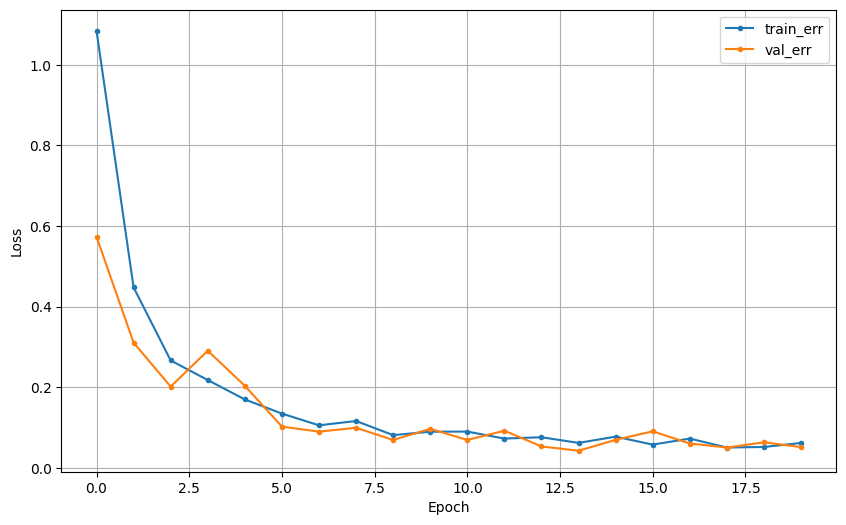

In [26]:
dl_history_plot(history2)

- base model 보다 더 낮은 loss를 가지지만, epoch 15 이후에 약간 상승함
- model 초기 1번 돌렸을 때 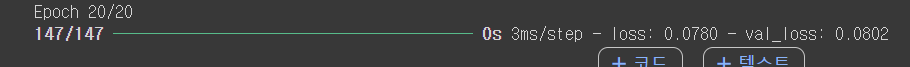

##### 모델 반복학습

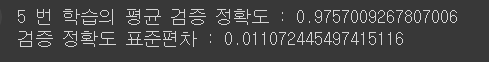

In [27]:
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")

    model2 = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation = 'relu'),
                         Dense(64, activation = 'relu'),
                         Dense(32, activation = 'relu'),
                         Dense(16, activation = 'relu'),
                         Dense(8, activation = 'relu'),
                         Dense(6, activation = 'softmax')])
    model2.summary()

    model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history2 = model2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)

    val_acc = history2.history['val_accuracy'][-1]
    accuracy_list.append(val_acc)

Model training run 1


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 2


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 3


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 4


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 5


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9757009267807006
 검증 정확도 표준편차 : 0.011072445497415116


### (3) 모델2 - 모델 2 과적합

In [29]:
model2_2 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model2_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model2_2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history2_2 = model2_2.fit(x_train, y_train, epochs=150, validation_data=(x_val, y_val)).history

Epoch 1/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4186 - val_loss: 0.8914
Epoch 2/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7688 - val_loss: 0.3587
Epoch 3/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3379 - val_loss: 0.2287
Epoch 4/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2439 - val_loss: 0.2749
Epoch 5/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2212 - val_loss: 0.1715
Epoch 6/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1824 - val_loss: 0.1495
Epoch 7/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1794 - val_loss: 0.1126
Epoch 8/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - val_loss: 0.3688
Epoch 9/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1544 - val_loss: 0.1077
Epoch 10/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0975 - val_loss: 0.0800
Epoch 11/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0976 - val_loss: 0.1173
Epoch 12/150
147/147 ━━━━━━━━━━━━━━━━━━━━

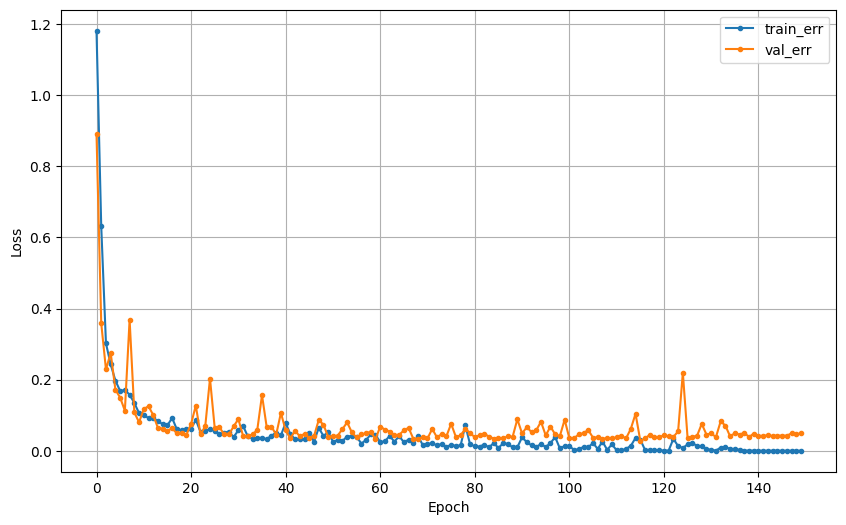

In [31]:
dl_history_plot(history2_2)

- epoch 120 이후에야 과적합 발생

#### 모델 L2 정규화
- 모든 특성이 적절해보이기에 가중치만 줄여줌

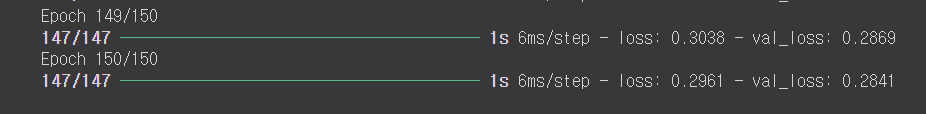

In [32]:
from keras.regularizers import l1, l2
model2_l2 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu', kernel_regularizer=l2(0.01)),
                     Dense(64, activation = 'relu', kernel_regularizer=l2(0.01)),
                     Dense(32, activation = 'relu', kernel_regularizer=l2(0.01)),
                     Dense(16, activation = 'relu', kernel_regularizer=l2(0.01)),
                     Dense(8, activation = 'relu', kernel_regularizer=l2(0.01)),
                     Dense(6, activation = 'softmax')])
model2_l2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model2_l2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history2_l2 = model2_l2.fit(x_train, y_train, epochs=150, validation_data=(x_val, y_val)).history

Epoch 1/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5533 - val_loss: 1.4493
Epoch 2/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2828 - val_loss: 1.0419
Epoch 3/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0025 - val_loss: 0.9535
Epoch 4/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8804 - val_loss: 0.7587
Epoch 5/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7838 - val_loss: 0.7179
Epoch 6/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7665 - val_loss: 0.6925
Epoch 7/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6983 - val_loss: 0.6805
Epoch 8/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7154 - val_loss: 0.6074
Epoch 9/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6481 - val_loss: 0.5813
Epoch 10/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6246 - val_loss: 0.8271
Epoch 11/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6447 - val_loss: 0.6263
Epoch 12/150
147/147 ━━━━━━━━━━━━━━━━━━━━

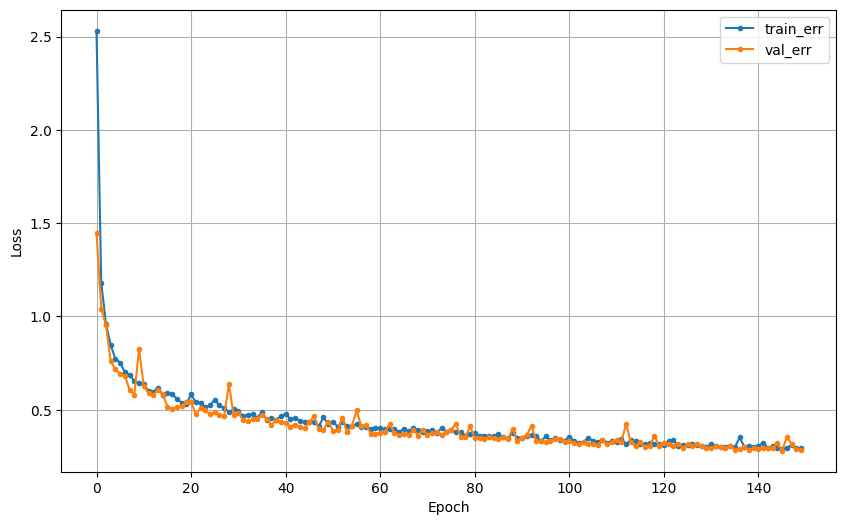

In [34]:
dl_history_plot(history2_l2)

#### 모델 dropout 정규화

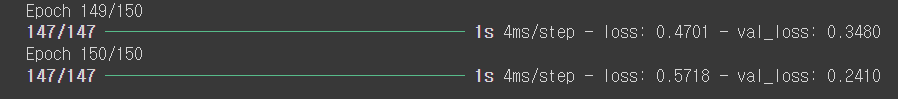

In [35]:
model2_d = Sequential([Input(shape = (nfeatures,)),
                       Dense(128, activation = 'relu'),
                       Dropout(0.3),
                       Dense(64, activation = 'relu'),
                       Dropout(0.3),
                       Dense(32, activation = 'relu'),
                       Dropout(0.3),
                       Dense(16, activation = 'relu'),
                       Dropout(0.3),
                       Dense(8, activation = 'relu'),
                       Dropout(0.3),
                       Dense(6, activation = 'softmax')])
model2_d.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model2_d.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history2_d = model2_d.fit(x_train, y_train, epochs=150, validation_data=(x_val, y_val)).history

Epoch 1/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7569 - val_loss: 1.5483
Epoch 2/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5234 - val_loss: 1.0311
Epoch 3/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1959 - val_loss: 0.8465
Epoch 4/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0163 - val_loss: 0.6539
Epoch 5/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8770 - val_loss: 0.5393
Epoch 6/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8167 - val_loss: 0.4975
Epoch 7/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7398 - val_loss: 0.4471
Epoch 8/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7040 - val_loss: 0.4124
Epoch 9/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7114 - val_loss: 0.4021
Epoch 10/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6690 - val_loss: 0.4004
Epoch 11/150
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6189 - val_loss: 0.3645
Epoch 12/150
147/147 ━━━━━━━━━━━━━━━━━━━━

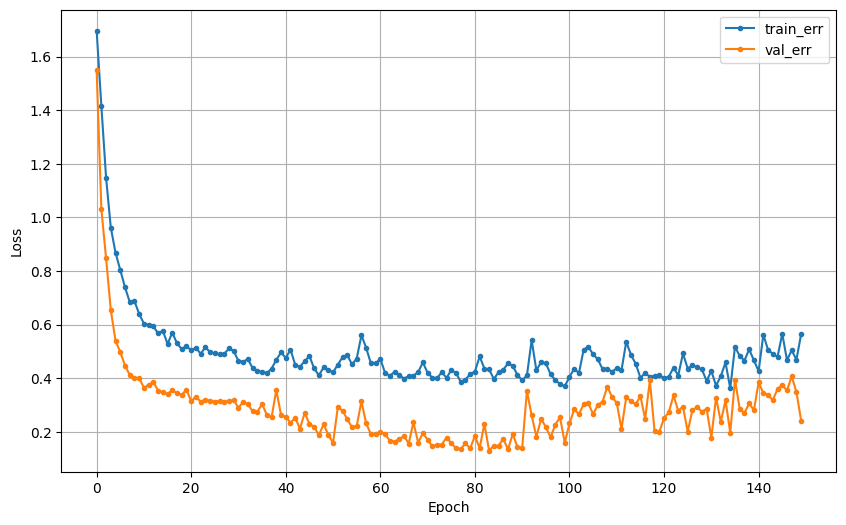

In [37]:
dl_history_plot(history2_d)

- 가중치 규제를 실행해도 val loss 가 본래 모델링 보다 낮게 나오기에 해당 모델링에서는 epoch 수를 제한하는 early stopping이 더 적합하다.

### (4) 모델3

- hidden layer 3
- early stopping
- 성능은 별로 좋지 않음

In [38]:
model3 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model3.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping
min_de = 0.001
pat = 5

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)
history3 = model3.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks = [es]).history

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.2161 - val_loss: 0.5634
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5702 - val_loss: 0.4207
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4602 - val_loss: 0.2820
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3123 - val_loss: 0.1928
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2423 - val_loss: 0.2450
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1944 - val_loss: 0.0974
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1214 - val_loss: 0.1111
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1217 - val_loss: 0.1724
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1521 - val_loss: 0.0675
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0836 - val_loss: 0.1113
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1067 - val_loss: 0.3597
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━

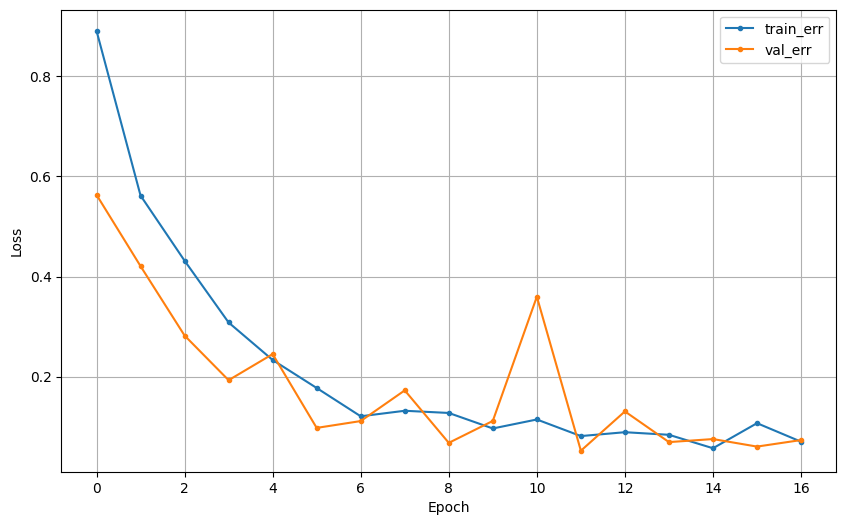

In [40]:
dl_history_plot(history3)

#### 모델 반복학습

In [41]:
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")
    model3 = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation = 'relu'),
                         Dense(32, activation = 'relu'),
                         Dense(8, activation = 'relu'),
                         Dense(6, activation = 'softmax')])
    model3.summary()

    model3.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    min_de = 0.001
    pat = 5
    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    history3 = model3.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es], verbose=0).history

    val_acc = history3['val_accuracy'][-1]
    accuracy_list.append(val_acc)


Model training run 1


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 2


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 3


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 4


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 5


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,382 (298.37 KB)

 Trainable params: 76,382 (298.37 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9096006751060486
 검증 정확도 표준편차 : 0.14006545566454517


### (5) 모델4

- hidden layer 활성화함수 sigmoid 변경, 학습률 0.01 정확도 0.83
- hidden layer 활성화함수 relu 유지 & 마지막 노드 수 10 정확도 0.95

In [43]:
model4 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'sigmoid'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'sigmoid'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model4.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                     │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model4.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)).history

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2879 - loss: 1.4788 - val_accuracy: 0.5217 - val_loss: 1.1839
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5045 - loss: 1.0354 - val_accuracy: 0.5353 - val_loss: 0.7912
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5361 - loss: 0.7923 - val_accuracy: 0.5319 - val_loss: 0.7743
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5453 - loss: 0.7742 - val_accuracy: 0.5582 - val_loss: 0.7586
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5258 - loss: 0.7784 - val_accuracy: 0.5268 - val_loss: 0.7772
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5422 - loss: 0.7681 - val_accuracy: 0.5548 - val_loss: 0.7547
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5473 - loss: 0.7669 - val_accuracy: 0.5854 - val_loss: 0.7457
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5359 - loss: 0.7658 - val_accuracy: 0.

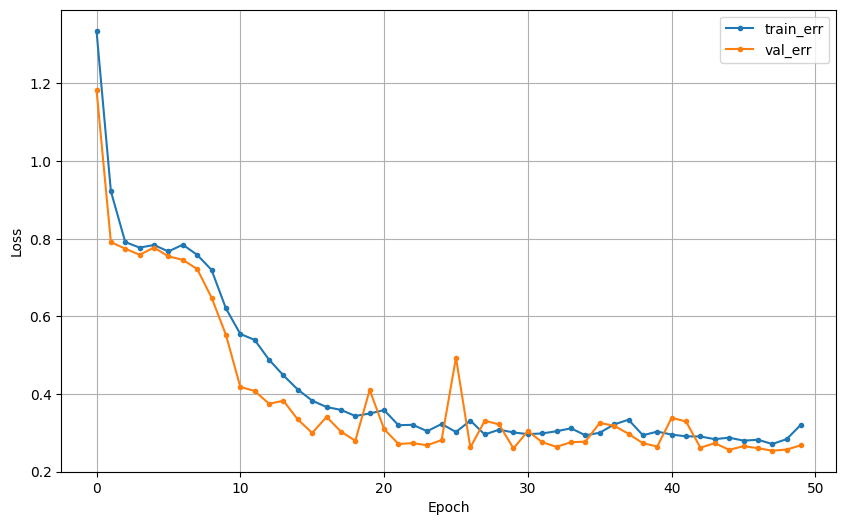

In [45]:
dl_history_plot(history4)

#### 모델 반복학습

In [55]:
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")
    model4 = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation = 'relu'),
                         Dense(64, activation = 'relu'),
                         Dense(32, activation = 'relu'),
                         Dense(16, activation = 'relu'),
                         Dense(10, activation = 'relu'),
                         Dense(6, activation = 'softmax')])
    model4.summary()

    model4.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    min_de = 0.001
    pat = 5
    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    history4 = model4.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es], verbose=0).history

    val_acc = history4['val_accuracy'][-1]
    accuracy_list.append(val_acc)

Model training run 1


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_121 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,036 (324.36 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 2


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_127 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,036 (324.36 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 3


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,036 (324.36 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 4


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_139 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,036 (324.36 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 5


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,036 (324.36 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9502124071121216
 검증 정확도 표준편차 : 0.02436848293081162


##### learning rate scheduler

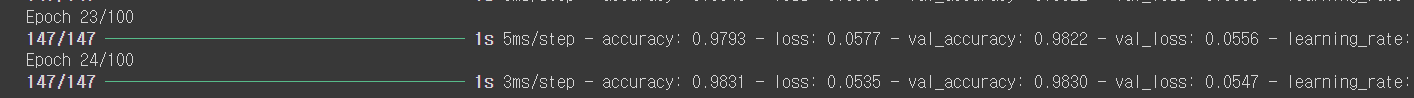

- Learning Rate Scheduler 사용
- 초기 0.001 10epoch마다 0.1배씩 학습률 감소

In [59]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

min_de = 0.001
pat = 5
es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

In [60]:
model4_lr = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'sigmoid'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'sigmoid'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model4_lr.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_157 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model4_lr.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4_lr = model4_lr.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, lr_scheduler]).history

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2779 - loss: 1.6063 - val_accuracy: 0.4647 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5064 - loss: 0.9986 - val_accuracy: 0.6967 - val_loss: 0.7947 - learning_rate: 0.0010
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7175 - loss: 0.7024 - val_accuracy: 0.7749 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8007 - loss: 0.5108 - val_accuracy: 0.8980 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.3231 - val_accuracy: 0.9388 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9361 - loss: 0.2011 - val_accuracy: 0.9431 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9321 - loss: 0.

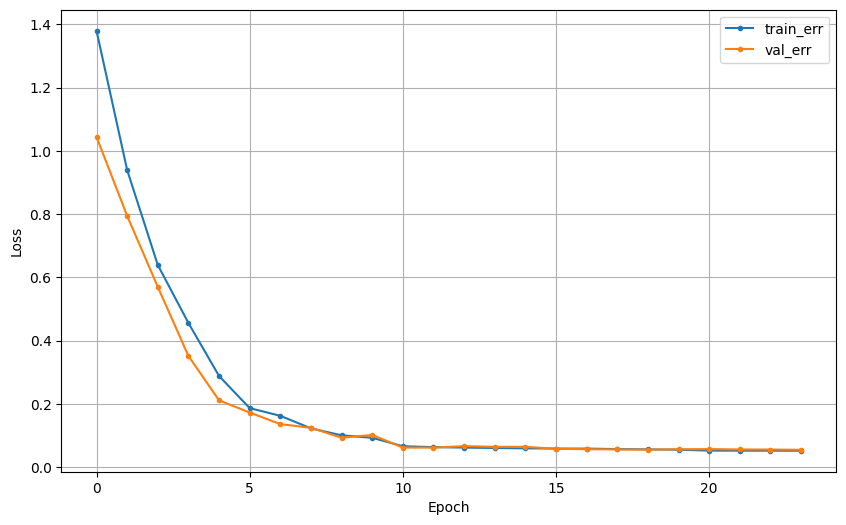

In [62]:
dl_history_plot(history4_lr)

In [63]:
# model 4 (마지막 노드 10)에 learning rate schedule 추가: es 만 추가한 모델링 성능이 더 높음
model4_1 = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(10, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model4.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,110 (973.09 KB)

 Trainable params: 83,036 (324.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,074 (648.73 KB)

In [64]:
model4_1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4_1 = model4_1.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, lr_scheduler]).history

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4198 - loss: 1.3698 - val_accuracy: 0.8513 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8684 - loss: 0.3877 - val_accuracy: 0.8258 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - loss: 0.2425 - val_accuracy: 0.9507 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9401 - loss: 0.1601 - val_accuracy: 0.9363 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9443 - loss: 0.1295 - val_accuracy: 0.9720 - val_loss: 0.0847 - learning_rate: 0.0010


### (5) 모델 5

- hidden layer 7개로 늘림


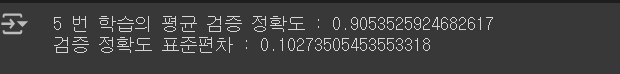

In [70]:
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")
    model5 = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(10, activation='relu'),
                         Dense(6, activation='softmax')
                         ])
    model5.summary()

    model5.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    min_de = 0.001
    pat = 5
    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    history5 = model5.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es], verbose=0).history

    val_acc = history5['val_accuracy'][-1]
    accuracy_list.append(val_acc)

Model training run 1


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_220 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_222 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_223 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_224 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 2


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_226 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_227 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_228 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_231 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_232 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 3


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_233 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_234 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_235 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_236 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_237 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_238 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_240 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 4


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_241 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_245 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_246 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 5


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_249 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_250 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_251 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_252 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_253 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_255 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9053525924682617
 검증 정확도 표준편차 : 0.10273505453553318


##### hidden layer 7개 lr 추가

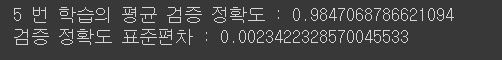

In [73]:
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")
    model5_lr = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(10, activation='relu'),
                         Dense(6, activation='softmax')
                         ])
    model5_lr.summary()

    model5_lr.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    min_de = 0.001
    pat = 5
    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    history5_lr = model5_lr.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, lr_scheduler], verbose=0).history

    val_acc = history5_lr['val_accuracy'][-1]
    accuracy_list.append(val_acc)

Model training run 1


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_265 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_266 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_270 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 2


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_275 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_276 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_277 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_278 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_279 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_280 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 3


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_281 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_282 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_283 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_284 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_285 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_286 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_287 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_288 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 4


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_289 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_290 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_291 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_292 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_293 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_294 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_295 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_296 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

Model training run 5


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_300 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_301 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,252 (344.73 KB)

 Trainable params: 88,252 (344.73 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9847068786621094
 검증 정확도 표준편차 : 0.0023422328570045533


##### batchnormalization

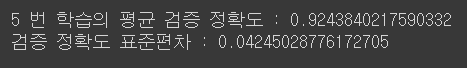

In [79]:
from tensorflow.keras.layers import BatchNormalization
accuracy_list = []
n_repeats = 5

for i in range(n_repeats):
    print(f"Model training run {i + 1}")
    model5_1 = Sequential([Input(shape = (nfeatures,)),
                         Dense(128, activation='relu'),
                         BatchNormalization(),
                         Dense(64, activation='relu'),
                         #Dense(64, activation='relu'),
                         BatchNormalization(),
                         #Dense(32, activation='relu'),
                         Dense(32, activation='relu'),
                         BatchNormalization(),
                         Dense(16, activation='relu'),
                         BatchNormalization(),
                         Dense(8, activation='relu'), #10
                         BatchNormalization(),
                         Dense(6, activation='softmax')
                         ])
    model5_1.summary()

    model5_1.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    min_de = 0.001
    pat = 5
    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    history5_1 = model5_1.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es], verbose=0).history

    val_acc = history5_1['val_accuracy'][-1]
    accuracy_list.append(val_acc)

Model training run 1


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_346 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_347 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_348 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_349 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_350 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_351 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,982 (328.05 KB)

 Trainable params: 83,486 (326.12 KB)

 Non-trainable params: 496 (1.94 KB)

Model training run 2


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_352 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_353 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_354 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_355 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_356 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_357 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,982 (328.05 KB)

 Trainable params: 83,486 (326.12 KB)

 Non-trainable params: 496 (1.94 KB)

Model training run 3


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_358 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_359 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_360 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_361 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_362 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_363 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,982 (328.05 KB)

 Trainable params: 83,486 (326.12 KB)

 Non-trainable params: 496 (1.94 KB)

Model training run 4


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_365 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_366 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_367 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_368 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_369 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,982 (328.05 KB)

 Trainable params: 83,486 (326.12 KB)

 Non-trainable params: 496 (1.94 KB)

Model training run 5


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_371 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_372 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_374 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_375 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,982 (328.05 KB)

 Trainable params: 83,486 (326.12 KB)

 Non-trainable params: 496 (1.94 KB)

In [80]:
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f" {n_repeats} 번 학습의 평균 검증 정확도 : {mean_accuracy}")
print(f" 검증 정확도 표준편차 : {std_accuracy}")

 5 번 학습의 평균 검증 정확도 : 0.9410365223884583
 검증 정확도 표준편차 : 0.01708217797386893


In [98]:
from tensorflow.keras.optimizers import Adagrad
model_plus = Sequential([Input(shape = (nfeatures,)),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model_plus.summary()
model_plus.compile(optimizer=Adagrad(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_388 (Dense)                    │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_389 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_390 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_391 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_392 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_393 (Dense)                    │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3752 - loss: 1.4658 - val_accuracy: 0.6117 - val_loss: 0.7900
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 0.7650 - val_accuracy: 0.7757 - val_loss: 0.5547
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7404 - loss: 0.5685 - val_accuracy: 0.6100 - val_loss: 0.7237
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.4749 - val_accuracy: 0.8624 - val_loss: 0.3716
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8288 - loss: 0.4023 - val_accuracy: 0.8403 - val_loss: 0.3783
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8500 - loss: 0.3609 - val_accuracy: 0.8904 - val_loss: 0.2779
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.3067 - val_accuracy: 0.9031 - val_loss: 0.2642
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - loss: 0.2791 - val_accuracy: 0.

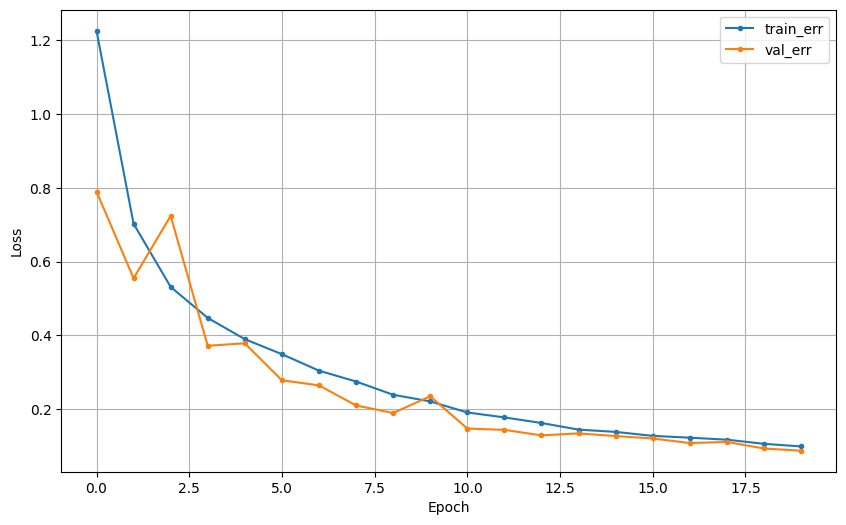

In [99]:
history_plus = model_plus.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val)).history
dl_history_plot(history_plus)

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [84]:
test.shape

(1471, 562)

In [86]:
target = 'Activity'
x_test = test.drop(target, axis=1)
y_test = test.loc[:, target]

x_test_scaled = scaler.transform(x_test)
y_test = y_test.map({'LAYING':0, 'STANDING':1, 'SITTING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})

In [88]:
x_test_scaled.shape, y_test.shape

((1471, 561), (1471,))

In [89]:
p1 = model2.predict(x_test_scaled)
p1 = p1.argmax(axis = 1)

print(confusion_matrix(y_test, p1))
print(classification_report(y_test, p1))
print(accuracy_score(y_test, p1))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[291   0   1   0   0   0]
 [  0 278   9   0   0   0]
 [  1  23 230   0   0   0]
 [  0   0   0 227   1   0]
 [  0   0   1   1 213   0]
 [  0   0   0   0   2 193]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.92      0.97      0.95       287
           2       0.95      0.91      0.93       254
           3       1.00      1.00      1.00       228
           4       0.99      0.99      0.99       215
           5       1.00      0.99      0.99       195

    accuracy                           0.97      1471
   macro avg       0.98      0.97      0.98      1471
weighted avg       0.97      0.97      0.97      1471

0.973487423521414


In [92]:
p2 = model4_lr.predict(x_test_scaled)
p2 = p2.argmax(axis = 1)

print(confusion_matrix(y_test, p2))
print(classification_report(y_test, p2))
print(accuracy_score(y_test, p2))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[290   1   1   0   0   0]
 [  0 270  17   0   0   0]
 [  0  16 238   0   0   0]
 [  0   0   0 226   2   0]
 [  0   0   0   2 213   0]
 [  0   0   0   0   1 194]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.94      0.94      0.94       287
           2       0.93      0.94      0.93       254
           3       0.99      0.99      0.99       228
           4       0.99      0.99      0.99       215
           5       1.00      0.99      1.00       195

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

0.972807613868117


In [93]:
p3 = model5_lr.predict(x_test_scaled)
p3 = p3.argmax(axis = 1)

print(confusion_matrix(y_test, p3))
print(classification_report(y_test, p3))
print(accuracy_score(y_test, p3))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[292   0   0   0   0   0]
 [  0 269  18   0   0   0]
 [  0  13 241   0   0   0]
 [  0   0   0 224   4   0]
 [  0   0   0   1 214   0]
 [  0   0   0   0   3 192]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.94      0.95       287
           2       0.93      0.95      0.94       254
           3       1.00      0.98      0.99       228
           4       0.97      1.00      0.98       215
           5       1.00      0.98      0.99       195

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

0.973487423521414
